In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs are available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU found. TensorFlow will use CPU.")

2025-05-29 00:03:15.832120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748466195.850547    9401 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748466195.855979    9401 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748466195.870457    9401 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748466195.870485    9401 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748466195.870503    9401 computation_placer.cc:177] computation placer alr

GPUs are available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
images_path = '256x256_mitochondria/images'
masks_path = '256x256_mitochondria/groundtruths'

image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith('.tif')])

def load_dataset():
    images = []
    masks = []

    for i in range(len(image_files)):
        # Load Images
        img_path = os.path.join(images_path, image_files[i])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images.append(image)

        # Load masks
        mask_path = os.path.join(masks_path, mask_files[i])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.uint8)  
        masks.append(mask)

    return np.array(images), np.array(masks)

def preprocess_data(images, masks):
    # normalize
    images = images.astype(np.float32) / 255.0
    masks = masks.astype(np.float32)

    # Reshape 
    images = images.reshape(-1, 256, 256, 1)
    masks = masks.reshape(-1, 256, 256, 1)

    return images, masks

def create_train_test_split(images, masks, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(
        images, masks, test_size=test_size, random_state=42
    )
    return X_train, X_test, y_train, y_test

images, masks = load_dataset()
images, masks = preprocess_data(images, masks)
X_train, X_test, y_train, y_test = create_train_test_split(images, masks)

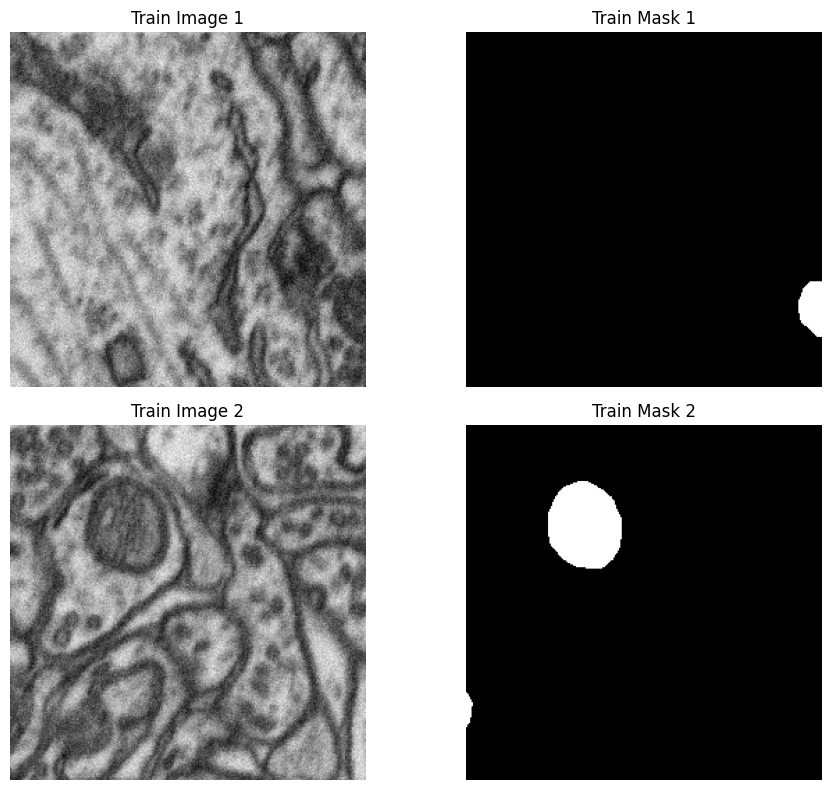

In [4]:
import matplotlib.pyplot as plt

# Show 2 sample
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i in range(2):
    # Original image
    axes[i, 0].imshow(X_train[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title(f'Train Image {i+1}')
    axes[i, 0].axis('off')
    
    # Mask
    axes[i, 1].imshow(y_train[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title(f'Train Mask {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)   
    s2, p2 = encoder_block(p1, 32)      
    s3, p3 = encoder_block(p2, 64)      

    b1 = conv_block(p3, 128)            

    d1 = decoder_block(b1, s3, 64)      
    d2 = decoder_block(d1, s2, 32)      
    d3 = decoder_block(d2, s1, 16)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d3)
    print(f"Using {activation} activation for {n_classes} classes")

    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [7]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1748466198.430746    9401 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2604 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Using sigmoid activation for 1 classes


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 484,561 (1.85 MB)

 Trainable params: 483,153 (1.84 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [8]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=40,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/40


I0000 00:00:1748466205.467204    9491 service.cc:152] XLA service 0x7fac80078890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748466205.467244    9491 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-05-29 00:03:25.688308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748466207.046841    9491 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-29 00:03:27.585687: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.45 = (f32[16,16,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,256,256]{3,2,1,0} %bitcast.12770, f32[16,1,3,3]{3,2,1,0} %bitcast.12777, f32[16]{0} %bitcast.15772), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3780 - loss: 0.8647

2025-05-29 00:03:48.190799: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.45 = (f32[8,16,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,1,256,256]{3,2,1,0} %bitcast.12768, f32[16,1,3,3]{3,2,1,0} %bitcast.12775, f32[16]{0} %bitcast.15657), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_1/convolution" source_file="/home/tako/Documents/ceng506_hw3/venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-29 00:03:48.372176: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3791 - loss: 0.8634   

2025-05-29 00:04:02.692323: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.51 = (f32[2,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,32,32]{3,2,1,0} %bitcast.1736, f32[128,64,3,3]{3,2,1,0} %bitcast.1743, f32[128]{0} %bitcast.1745), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_6_1/convolution" source_file="/home/tako/Documents/ceng506_hw3/venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-29 00:04:02.770268: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3802 - loss: 0.8623 - val_accuracy: 0.0500 - val_loss: 0.7070
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.4750 - loss: 0.7693 - val_accuracy: 0.0485 - val_loss: 0.7167
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5810 - loss: 0.6779 - val_accuracy: 0.1072 - val_loss: 0.7054
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.6853 - loss: 0.6041 - val_accuracy: 0.8456 - val_loss: 0.6812
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.7754 - loss: 0.5505 - val_accuracy: 0.9419 - val_loss: 0.6559
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.8437 - loss: 0.5094 - val_accuracy: 0.9468 - val_loss: 0.6372
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9012 - loss: 0.4745 - val_accuracy: 0.5319 - val_loss: 0.6765
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9403 - loss: 0.4418 - val_accuracy: 0.1250 - val_lo

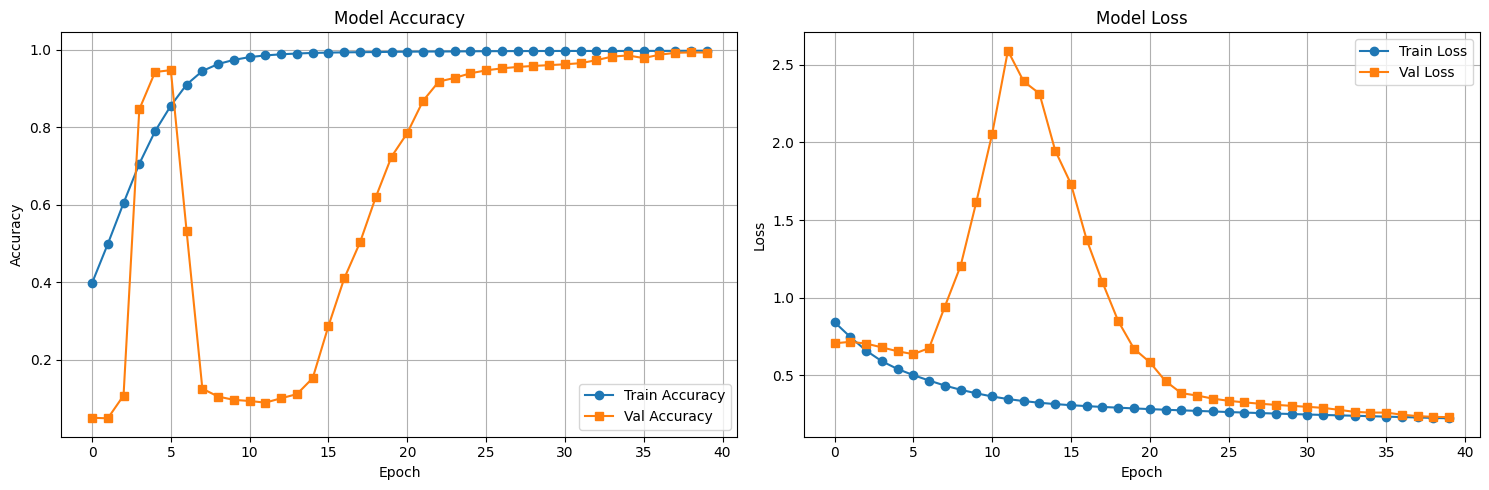

🎯 Best val_accuracy: 0.9926 (Epoch 39)
🎯 Best val_loss: 0.2320 (Epoch 40)
📈 Final val_accuracy: 0.9920
📉 Final val_loss: 0.2320


In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Training & Validation Accuracy
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    best_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    best_loss_epoch = history.history['val_loss'].index(best_val_loss) + 1
    
    print(f"🎯 Best val_accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})")
    print(f"🎯 Best val_loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})")
    print(f"📈 Final val_accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"📉 Final val_loss: {history.history['val_loss'][-1]:.4f}")

plot_training_history(history)


In [13]:
threshold = 0.5
y_pred=model.predict(X_test)
y_pred_bin = (y_pred > threshold).astype("uint8")[..., 0]                    
y_true_bin = y_test[..., 0] if y_test.ndim == 4 else y_test


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 


In [14]:
from tensorflow.keras.metrics import MeanIoU
iou_metric = MeanIoU(num_classes=2)
iou_metric.update_state(y_true_bin, y_pred_bin)
print("Mean IoU =", iou_metric.result().numpy())

Mean IoU = 0.92260134


(1, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(256, 256)


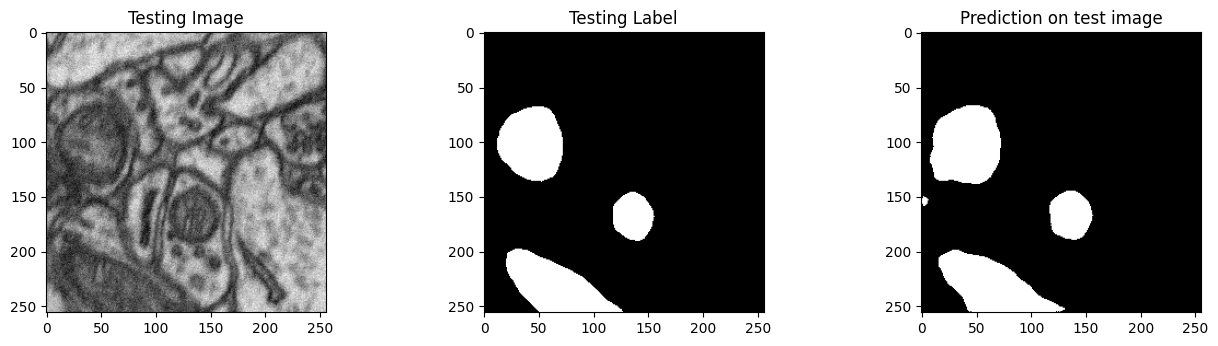

In [16]:
import random
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()